In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from tqdm import tqdm



In [2]:
train_dataset_path = 'C:\\Users\\PC\\Desktop\\lisnen_data\\validation_data\\train'
val_dataset_path = 'C:\\Users\\PC\\Desktop\\lisnen_data\\validation_data\\val'


In [3]:

# Define transformations for the training and validation sets
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # Ensures the data is converted to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Ensures the data is converted to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_dataset = datasets.ImageFolder(root=train_dataset_path, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dataset_path, transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


In [4]:
# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer to output 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

c:\Users\PC\anaconda3\envs\crnn\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC\anaconda3\envs\crnn\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
# applying spatial attention
import torch
import torch.nn as nn
from torchvision import models

# Define the Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels // 8, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attention = self.conv1(x)
        attention = self.conv2(attention)
        attention = self.sigmoid(attention)
        return x * attention,attention

# Integrate the Spatial Attention Module into ResNet-50
class ResNet50WithAttention(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50WithAttention, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.attention = SpatialAttention(in_channels=2048)  # 2048 channels after layer4 in ResNet-50
        self.fc = nn.Linear(2048, num_classes)  # Adjust the final fully connected layer

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x,attention = self.attention(x)  # Apply the attention mechanism here

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x,attention

# Instantiate the model
num_classes = 4  # Number of classes for your audio event classification
model = ResNet50WithAttention(num_classes=num_classes)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [7]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

# Training function with progress bar and metric tracking
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    train_precision_history = []
    val_precision_history = []
    train_recall_history = []
    val_recall_history = []
    train_f1_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()  # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=f'{phase} {epoch}/{num_epochs - 1}'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs, _ = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            epoch_precision = precision_score(all_labels, all_preds, average='weighted')
            epoch_recall = recall_score(all_labels, all_preds, average='weighted')
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f} F1 Score: {epoch_f1:.4f}')

            # Save the metrics
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                train_precision_history.append(epoch_precision)
                train_recall_history.append(epoch_recall)
                train_f1_history.append(epoch_f1)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                val_precision_history.append(epoch_precision)
                val_recall_history.append(epoch_recall)
                val_f1_history.append(epoch_f1)

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_precision_history, val_precision_history, train_recall_history, val_recall_history, train_f1_history, val_f1_history

# Train the model
model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_precision_history, val_precision_history, train_recall_history, val_recall_history, train_f1_history, val_f1_history = train_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs=25)



Epoch 0/24
----------


train 0/24: 100%|██████████| 47/47 [00:19<00:00,  2.45it/s]


train Loss: 0.4958 Acc: 0.8158 Precision: 0.8210 Recall: 0.8158 F1 Score: 0.8180


val 0/24: 100%|██████████| 6/6 [00:03<00:00,  1.53it/s]


val Loss: 0.5248 Acc: 0.8495 Precision: 0.8491 Recall: 0.8495 F1 Score: 0.8329
Epoch 1/24
----------


train 1/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.3160 Acc: 0.8843 Precision: 0.8844 Recall: 0.8843 F1 Score: 0.8843


val 1/24: 100%|██████████| 6/6 [00:03<00:00,  1.56it/s]


val Loss: 1.0931 Acc: 0.7312 Precision: 0.7893 Recall: 0.7312 F1 Score: 0.7203
Epoch 2/24
----------


train 2/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.2484 Acc: 0.9202 Precision: 0.9204 Recall: 0.9202 F1 Score: 0.9203


val 2/24: 100%|██████████| 6/6 [00:03<00:00,  1.60it/s]


val Loss: 0.2737 Acc: 0.9032 Precision: 0.9096 Recall: 0.9032 F1 Score: 0.9018
Epoch 3/24
----------


train 3/24: 100%|██████████| 47/47 [00:18<00:00,  2.52it/s]


train Loss: 0.2196 Acc: 0.9202 Precision: 0.9204 Recall: 0.9202 F1 Score: 0.9203


val 3/24: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


val Loss: 0.2149 Acc: 0.9301 Precision: 0.9316 Recall: 0.9301 F1 Score: 0.9306
Epoch 4/24
----------


train 4/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.1718 Acc: 0.9388 Precision: 0.9390 Recall: 0.9388 F1 Score: 0.9389


val 4/24: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


val Loss: 0.2253 Acc: 0.9247 Precision: 0.9339 Recall: 0.9247 F1 Score: 0.9247
Epoch 5/24
----------


train 5/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.1472 Acc: 0.9528 Precision: 0.9532 Recall: 0.9528 F1 Score: 0.9529


val 5/24: 100%|██████████| 6/6 [00:03<00:00,  1.60it/s]


val Loss: 0.4862 Acc: 0.8656 Precision: 0.8935 Recall: 0.8656 F1 Score: 0.8446
Epoch 6/24
----------


train 6/24: 100%|██████████| 47/47 [00:18<00:00,  2.52it/s]


train Loss: 0.1663 Acc: 0.9422 Precision: 0.9422 Recall: 0.9422 F1 Score: 0.9421


val 6/24: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


val Loss: 0.3036 Acc: 0.9140 Precision: 0.9223 Recall: 0.9140 F1 Score: 0.9159
Epoch 7/24
----------


train 7/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.1278 Acc: 0.9601 Precision: 0.9603 Recall: 0.9601 F1 Score: 0.9601


val 7/24: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


val Loss: 0.2557 Acc: 0.9086 Precision: 0.9272 Recall: 0.9086 F1 Score: 0.9121
Epoch 8/24
----------


train 8/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.1354 Acc: 0.9574 Precision: 0.9575 Recall: 0.9574 F1 Score: 0.9575


val 8/24: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


val Loss: 0.1906 Acc: 0.9247 Precision: 0.9247 Recall: 0.9247 F1 Score: 0.9247
Epoch 9/24
----------


train 9/24: 100%|██████████| 47/47 [00:18<00:00,  2.53it/s]


train Loss: 0.1065 Acc: 0.9661 Precision: 0.9663 Recall: 0.9661 F1 Score: 0.9662


val 9/24: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


val Loss: 0.2406 Acc: 0.9301 Precision: 0.9323 Recall: 0.9301 F1 Score: 0.9303
Epoch 10/24
----------


train 10/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.0711 Acc: 0.9741 Precision: 0.9741 Recall: 0.9741 F1 Score: 0.9741


val 10/24: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


val Loss: 0.1492 Acc: 0.9570 Precision: 0.9593 Recall: 0.9570 F1 Score: 0.9577
Epoch 11/24
----------


train 11/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.0971 Acc: 0.9641 Precision: 0.9641 Recall: 0.9641 F1 Score: 0.9641


val 11/24: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


val Loss: 0.1521 Acc: 0.9409 Precision: 0.9452 Recall: 0.9409 F1 Score: 0.9416
Epoch 12/24
----------


train 12/24: 100%|██████████| 47/47 [00:18<00:00,  2.53it/s]


train Loss: 0.0944 Acc: 0.9668 Precision: 0.9668 Recall: 0.9668 F1 Score: 0.9666


val 12/24: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


val Loss: 0.3581 Acc: 0.8817 Precision: 0.9116 Recall: 0.8817 F1 Score: 0.8811
Epoch 13/24
----------


train 13/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.1192 Acc: 0.9574 Precision: 0.9576 Recall: 0.9574 F1 Score: 0.9574


val 13/24: 100%|██████████| 6/6 [00:03<00:00,  1.56it/s]


val Loss: 0.2250 Acc: 0.9140 Precision: 0.9135 Recall: 0.9140 F1 Score: 0.9135
Epoch 14/24
----------


train 14/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.0658 Acc: 0.9820 Precision: 0.9821 Recall: 0.9820 F1 Score: 0.9820


val 14/24: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


val Loss: 0.2431 Acc: 0.9247 Precision: 0.9258 Recall: 0.9247 F1 Score: 0.9246
Epoch 15/24
----------


train 15/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.0688 Acc: 0.9754 Precision: 0.9755 Recall: 0.9754 F1 Score: 0.9754


val 15/24: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


val Loss: 0.0851 Acc: 0.9516 Precision: 0.9520 Recall: 0.9516 F1 Score: 0.9515
Epoch 16/24
----------


train 16/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.0544 Acc: 0.9820 Precision: 0.9821 Recall: 0.9820 F1 Score: 0.9821


val 16/24: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


val Loss: 0.2196 Acc: 0.9462 Precision: 0.9484 Recall: 0.9462 F1 Score: 0.9461
Epoch 17/24
----------


train 17/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.0618 Acc: 0.9787 Precision: 0.9788 Recall: 0.9787 F1 Score: 0.9788


val 17/24: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


val Loss: 0.1857 Acc: 0.9140 Precision: 0.9270 Recall: 0.9140 F1 Score: 0.9169
Epoch 18/24
----------


train 18/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.0583 Acc: 0.9820 Precision: 0.9820 Recall: 0.9820 F1 Score: 0.9820


val 18/24: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


val Loss: 0.2034 Acc: 0.9462 Precision: 0.9477 Recall: 0.9462 F1 Score: 0.9458
Epoch 19/24
----------


train 19/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.0603 Acc: 0.9767 Precision: 0.9769 Recall: 0.9767 F1 Score: 0.9767


val 19/24: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


val Loss: 0.2789 Acc: 0.9086 Precision: 0.9097 Recall: 0.9086 F1 Score: 0.9080
Epoch 20/24
----------


train 20/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.0420 Acc: 0.9834 Precision: 0.9834 Recall: 0.9834 F1 Score: 0.9834


val 20/24: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


val Loss: 0.1762 Acc: 0.9355 Precision: 0.9354 Recall: 0.9355 F1 Score: 0.9353
Epoch 21/24
----------


train 21/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.0170 Acc: 0.9947 Precision: 0.9947 Recall: 0.9947 F1 Score: 0.9947


val 21/24: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


val Loss: 0.1905 Acc: 0.9301 Precision: 0.9316 Recall: 0.9301 F1 Score: 0.9306
Epoch 22/24
----------


train 22/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.0297 Acc: 0.9927 Precision: 0.9927 Recall: 0.9927 F1 Score: 0.9927


val 22/24: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


val Loss: 0.2504 Acc: 0.9247 Precision: 0.9244 Recall: 0.9247 F1 Score: 0.9241
Epoch 23/24
----------


train 23/24: 100%|██████████| 47/47 [00:18<00:00,  2.53it/s]


train Loss: 0.1045 Acc: 0.9654 Precision: 0.9654 Recall: 0.9654 F1 Score: 0.9654


val 23/24: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


val Loss: 0.1175 Acc: 0.9570 Precision: 0.9591 Recall: 0.9570 F1 Score: 0.9565
Epoch 24/24
----------


train 24/24: 100%|██████████| 47/47 [00:18<00:00,  2.53it/s]


train Loss: 0.0536 Acc: 0.9854 Precision: 0.9854 Recall: 0.9854 F1 Score: 0.9854


val 24/24: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]

val Loss: 0.1380 Acc: 0.9462 Precision: 0.9514 Recall: 0.9462 F1 Score: 0.9469


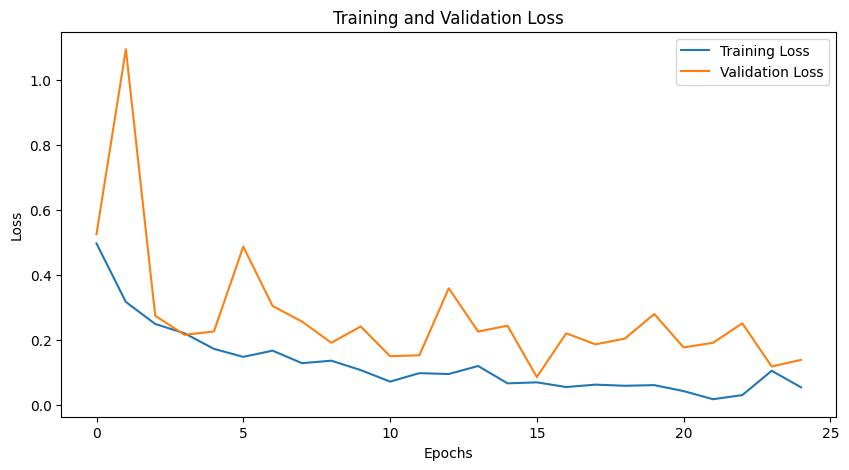

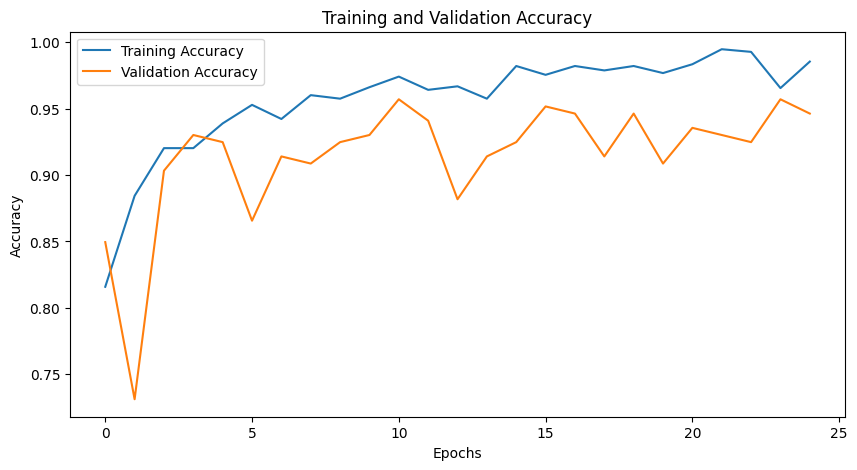

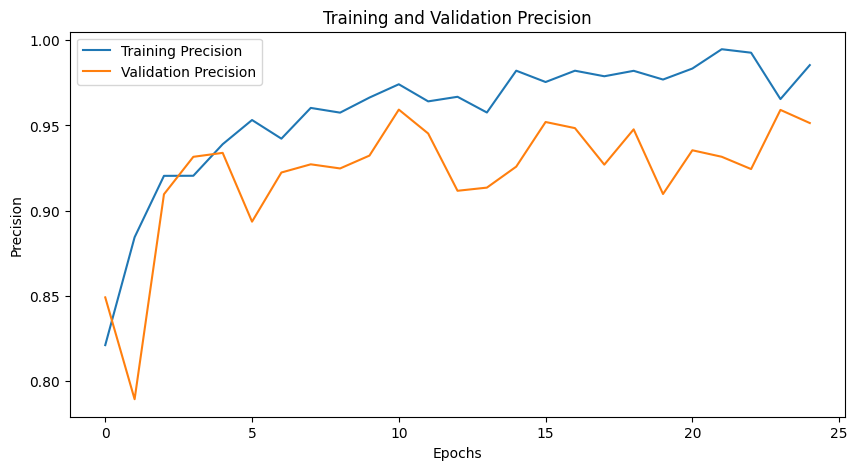

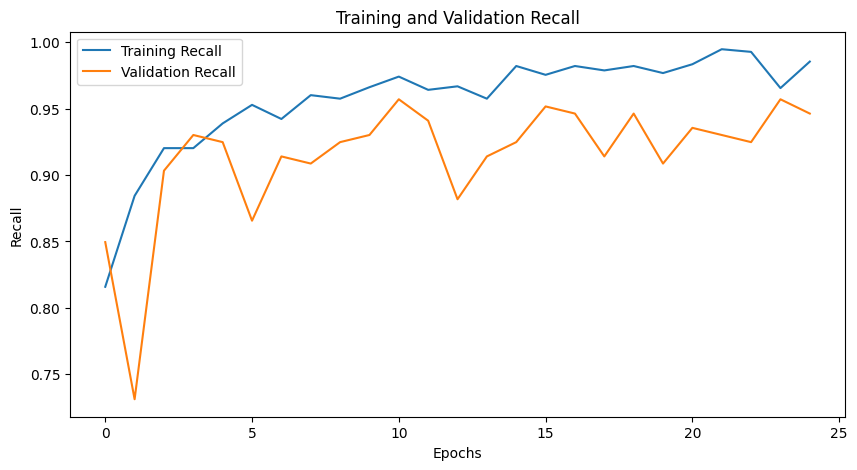

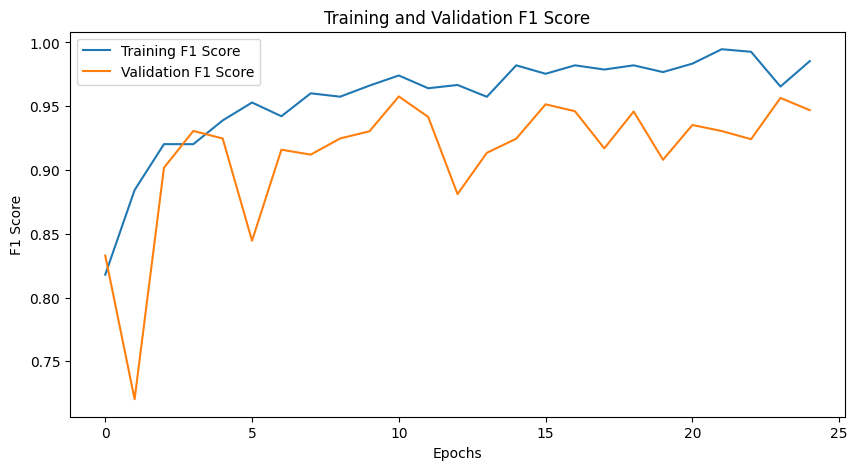

In [8]:
import numpy as np

# Convert tensor histories to numpy arrays
train_acc_history = np.array([x.cpu() for x in train_acc_history])
val_acc_history = np.array([x.cpu() for x in val_acc_history])
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation precision
plt.figure(figsize=(10, 5))
plt.plot(train_precision_history, label='Training Precision')
plt.plot(val_precision_history, label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot the training and validation recall
plt.figure(figsize=(10, 5))
plt.plot(train_recall_history, label='Training Recall')
plt.plot(val_recall_history, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

# Plot the training and validation F1 score
plt.figure(figsize=(10, 5))
plt.plot(train_f1_history, label='Training F1 Score')
plt.plot(val_f1_history, label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()


In [9]:
# Save the trained model to a specified path
save_path = 'C:\\Users\\PC\\Desktop\\lisnen_research_files\\audio_research_crnn_files\\model_weights\\resnet_50_attention.pth'
torch.save(model.state_dict(), save_path)

In [10]:
# Define the transformations for the test set
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the test dataset
test_dataset_path = 'C:\\Users\\PC\\Desktop\\lisnen_data\\validation_data\\test'
test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader, class_names):
    model.eval()  # Set model to evaluation mode
    running_corrects = 0
    all_preds = []
    all_labels = []
    wrong_predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs,_ = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Collect wrong predictions
            wrong_indices = np.where(preds.cpu().numpy() != labels.cpu().numpy())[0]
            for idx in wrong_indices:
                wrong_predictions.append((inputs.cpu()[idx], preds.cpu().numpy()[idx], labels.cpu().numpy()[idx]))

    accuracy = running_corrects.double() / len(dataloader.dataset)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1:.4f}')
    
    return wrong_predictions,all_labels,all_preds

# Evaluate the model on the test data
class_names = ['Baby Cry','Door Bell','Door Knock', 'Fire Alarm']
wrong_predictions = evaluate_model(model, test_loader, class_names)




Test Accuracy: 0.9378
Test Precision: 0.9398
Test Recall: 0.9378
Test F1 Score: 0.9371


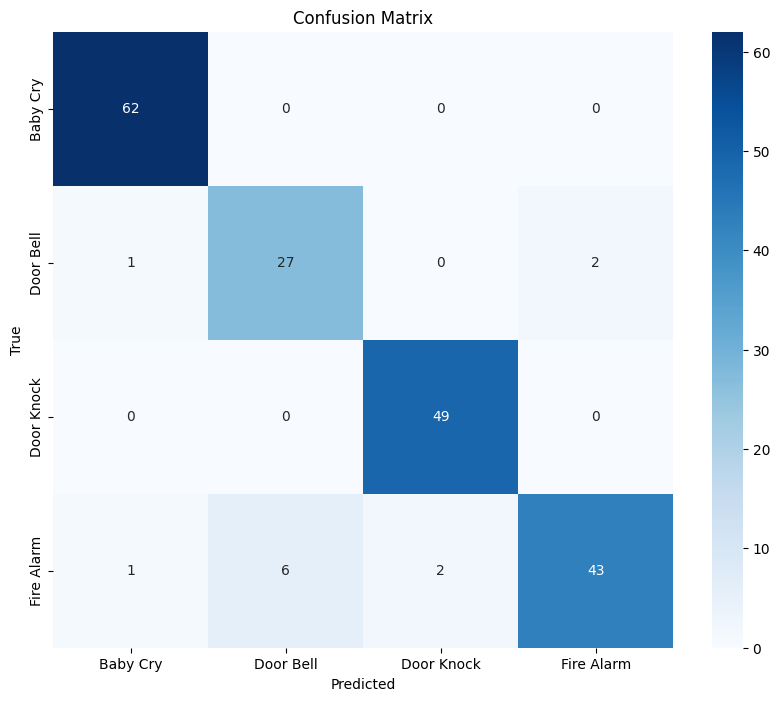

              precision    recall  f1-score   support

    Baby Cry       0.97      1.00      0.98        62
   Door Bell       0.82      0.90      0.86        30
  Door Knock       0.96      1.00      0.98        49
  Fire Alarm       0.96      0.83      0.89        52

    accuracy                           0.94       193
   macro avg       0.93      0.93      0.93       193
weighted avg       0.94      0.94      0.94       193

Class: Baby Cry
Precision: 0.9688
Recall: 1.0000
F1 Score: 0.9841
Support: 62.0
--------------------
Class: Door Bell
Precision: 0.8182
Recall: 0.9000
F1 Score: 0.8571
Support: 30.0
--------------------
Class: Door Knock
Precision: 0.9608
Recall: 1.0000
F1 Score: 0.9800
Support: 49.0
--------------------
Class: Fire Alarm
Precision: 0.9556
Recall: 0.8269
F1 Score: 0.8866
Support: 52.0
--------------------


In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model_with_confusion_matrix(model, dataloader, class_names):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs,_ = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Print individual metrics for each class
    for class_name, metrics in cr.items():
        if class_name in class_names:
            print(f"Class: {class_name}")
            print(f"Precision: {metrics['precision']:.4f}")
            print(f"Recall: {metrics['recall']:.4f}")
            print(f"F1 Score: {metrics['f1-score']:.4f}")
            print(f"Support: {metrics['support']}")
            print("-" * 20)

# Evaluate the model on the test data with confusion matrix and detailed metrics
evaluate_model_with_confusion_matrix(model, test_loader, class_names)


In [13]:
from PIL import Image
# Function to predict the class for a single input image
def predict_image(model, image_path, class_names):
    model.eval()  # Set model to evaluation mode
    image = Image.open(image_path).convert('RGB')
    image = test_transforms(image).unsqueeze(0)  # Apply transformations and add batch dimension

    with torch.no_grad():
        image = image.to(device)
        outputs,_ = model(image)
        _, preds = torch.max(outputs, 1)
        predicted_class = class_names[preds.item()]

    return predicted_class

# Assuming class_names is a list of class names corresponding to the classes in your dataset
class_names = test_dataset.classes

# Predict the class for an input image
image_path = "C:\\Users\\PC\\Desktop\\lisnen_data\\Melspectrograms\\Melspectrograms\\Fire_Alarm\\firealarm_audio_sample_44.png"
predicted_class = predict_image(model, image_path, class_names)
print(f'Predicted Class: {predicted_class}')

Predicted Class: Fire_Alarm_Spectrograms


# visualizing attention maps

In [14]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

c:\Users\PC\anaconda3\envs\crnn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\PC\AppData\Local\Temp\ipykernel_17592\1775370600.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


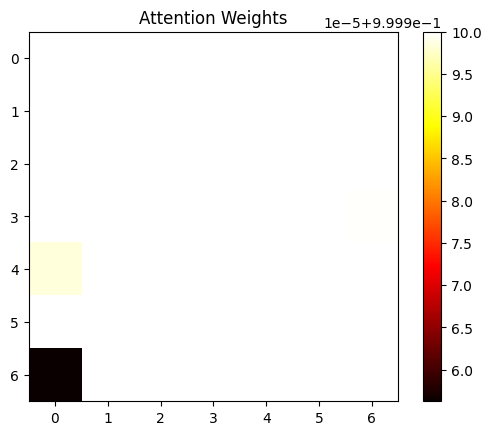

100%|██████████| 1000/1000 [01:48<00:00,  9.25it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].


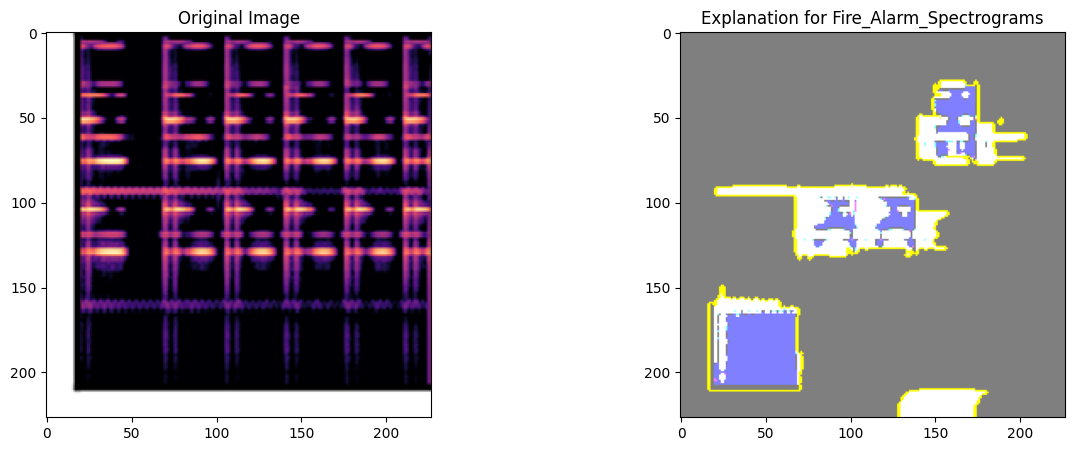

Prediction probabilities:
Baby_Cry_Spectrograms: -3.9805
Door_Bell_Spectrograms: 0.5966
Door_Knock_Spectrograms: -14.9349
Fire_Alarm_Spectrograms: 4.4667


In [20]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Load the fine-tuned model
model_path = 'model_weights/resnet_50_attention.pth'
state_dict = torch.load(model_path, map_location=device)
# Manually move each parameter to CPU
for key in state_dict:
    state_dict[key] = state_dict[key].cpu()
model.load_state_dict(state_dict)
model.eval()  # Set the model to evaluation mode
model = model.to(device)

# Verify all model parameters are on CPU
for param in model.parameters():
    if param.device.type != 'cpu':
        raise ValueError(f"Parameter found on {param.device.type}")

#print("All model parameters are on CPU")

# Define the image transformation
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to get model predictions
def get_predictions(images):
    model.eval()
    batch = torch.stack([test_transforms(Image.fromarray(img.astype('uint8'))) for img in images], dim=0)
    batch = batch.to(device)  # Ensure the batch is moved to the same device as the model
    #print(f"Input tensor device: {batch.device}")
    with torch.no_grad():
        outputs, attention = model(batch)  # Get both outputs and attention
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # Only take the predictions if model returns a tuple
    #print(f"Model weights device: {next(model.parameters()).device}")
    #print(f"Raw model output shape: {outputs.shape}")
    return outputs.numpy(),attention.numpy()

# Function to get image and make it numpy and RGB
def get_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f).convert('RGB')
    return np.array(img)

# LIME explanation function
def explain_prediction(image_path, model, class_names):
    # Load and preprocess the image
    image = get_image(image_path)
    
    # Get raw predictions
    raw_predictions,attention_weights = get_predictions([image])
    #print(f"Raw predictions shape: {raw_predictions.shape}")
    #print(f"Raw predictions: {raw_predictions}")
    # Visualize the attention weights
    plt.imshow(attention_weights[0][0], cmap='hot', interpolation='nearest')
    plt.title('Attention Weights')
    plt.colorbar()
    plt.show()
    # Create a LIME image explainer
    explainer = lime_image.LimeImageExplainer()
    
    # Get the explanation
    explanation = explainer.explain_instance(image, 
                                             classifier_fn=lambda x: get_predictions(x)[0],
                                             top_labels=4, 
                                             hide_color=0, 
                                             num_samples=1000)
    
    # Get the top prediction
    pred_class = explanation.top_labels[0]
    
    # Get the image and mask
    temp, mask = explanation.get_image_and_mask(pred_class, positive_only=True, num_features=5, hide_rest=True)
    
    # Create the visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax2.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    ax2.set_title(f'Explanation for {class_names[pred_class]}')
    
    plt.show()
    
    # Print the prediction probabilities
    print('Prediction probabilities:')
    for i, (class_name, prob) in enumerate(zip(class_names, raw_predictions[0])):
        print(f'{class_name}: {prob:.4f}')

# Assuming class_names is a list of class names corresponding to the classes in your dataset
class_names = ['Baby_Cry_Spectrograms', 'Door_Bell_Spectrograms', 'Door_Knock_Spectrograms', 'Fire_Alarm_Spectrograms']

# Use the function
image_path = "C:\\Users\\PC\\Desktop\\lisnen_data\\Melspectrograms\\Melspectrograms\\Fire_Alarm\\firealarm_audio_sample_44.png"
explain_prediction(image_path, model, class_names)

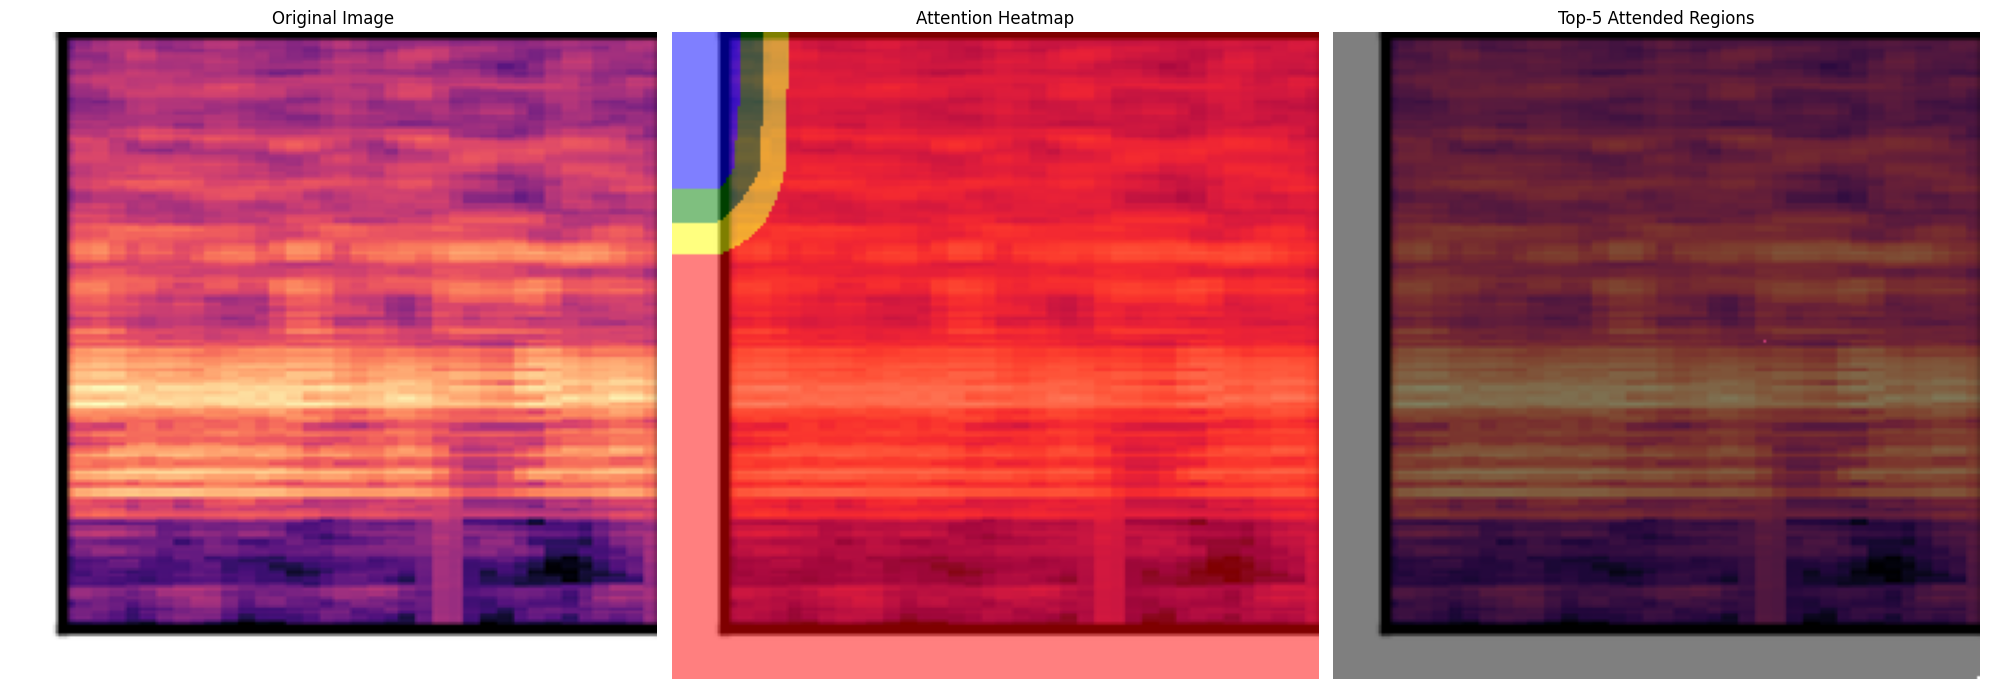

Prediction probabilities:
Baby_Cry_Spectrograms: -3.5371
Door_Bell_Spectrograms: 5.8925
Door_Knock_Spectrograms: -12.8108
Fire_Alarm_Spectrograms: -0.4351


In [26]:
from matplotlib.colors import LinearSegmentedColormap
# Modified image transformation
def get_transforms(num_channels):
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485] * num_channels, [0.229] * num_channels)
    ])

# Function to get model predictions and attention weights
def get_predictions_and_attention(image):
    model.eval()
    num_channels = 1 if len(image.shape) == 2 else 3
    test_transforms = get_transforms(num_channels)
    
    if num_channels == 1:
        image = Image.fromarray(image.astype('uint8'), mode='L')
    else:
        image = Image.fromarray(image.astype('uint8'), mode='RGB')
    
    img_tensor = test_transforms(image).unsqueeze(0)
    img_tensor = img_tensor.to(device)
    
    with torch.no_grad():
        outputs, attention = model(img_tensor)
    
    # Resize attention to match input image size
    attention = nn.functional.interpolate(attention, size=image.size[::-1], mode='bilinear', align_corners=False)
    attention = attention.squeeze().cpu().numpy()
    
    return outputs.squeeze().cpu().numpy(), attention

# Function to create attention heatmap
def create_attention_heatmap(image, attention, alpha=0.5):
    # Normalize attention
    attention = (attention - attention.min()) / (attention.max() - attention.min())
    
    # Create a color map
    colors = ['blue', 'green', 'yellow', 'red']
    n_bins = len(colors)
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
    
    # Create the heatmap
    heatmap = cmap(attention)
    heatmap = Image.fromarray((heatmap[:, :, :3] * 255).astype(np.uint8))
    
    # Overlay heatmap on original image
    original_img = Image.fromarray(image) if len(image.shape) == 3 else Image.fromarray(np.stack([image]*3, axis=-1))
    overlayed_img = Image.blend(original_img, heatmap, alpha)
    
    return np.array(overlayed_img)

# Function to highlight top-k attended regions
def highlight_top_k(image, attention, k=2):
    # Flatten the attention map
    flat_attention = attention.flatten()
    
    # Get indices of top k values
    top_k_indices = np.argsort(flat_attention)[-k:]
    
    # Create a mask for top k regions
    mask = np.zeros_like(attention)
    mask.flat[top_k_indices] = 1
    
    # Apply mask to the image
    highlighted_img = image.copy()
    if len(highlighted_img.shape) == 2:
        highlighted_img = np.stack([highlighted_img]*3, axis=-1)
    highlighted_img[mask == 0] = highlighted_img[mask == 0] // 2  # Darken non-highlighted regions
    
    return highlighted_img

# Function to visualize attention
def visualize_attention(image_path, model, class_names):
    # Load and preprocess the image
    image = np.array(Image.open(image_path).convert('RGB'))
    
    # Get predictions and attention weights
    predictions, attention = get_predictions_and_attention(image)
    
    # Create attention heatmap
    heatmap_img = create_attention_heatmap(image, attention)
    
    # Highlight top-k attended regions
    highlighted_img = highlight_top_k(image, attention)
    
    # Visualize
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
    
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    ax2.imshow(heatmap_img)
    ax2.set_title('Attention Heatmap')
    ax2.axis('off')
    
    ax3.imshow(highlighted_img)
    ax3.set_title('Top-5 Attended Regions')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print the prediction probabilities
    print('Prediction probabilities:')
    for i, (class_name, prob) in enumerate(zip(class_names, predictions)):
        print(f'{class_name}: {prob:.4f}')

# Use the function
image_path = "C:\\Users\\PC\\Desktop\\lisnen_data\\Melspectrograms\\Melspectrograms\\Door_Bell\\doorbell_audio-2.png"
visualize_attention(image_path, model, class_names)